In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

### 데이터 준비

In [5]:
train_dataset = torchvision.datasets.FashionMNIST("./data", download = True, train = True, transform = transforms.Compose([
    transforms.ToTensor()
]))
test_dataset = torchvision.datasets.FashionMNIST("./data", download = True, train = False, transform = transforms.Compose([
    transforms.ToTensor()
]))

In [6]:
# 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100)

In [7]:
# 분류 클래스 정의
labels_map = {
    0 : "T-Shirt",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle Boot"
}

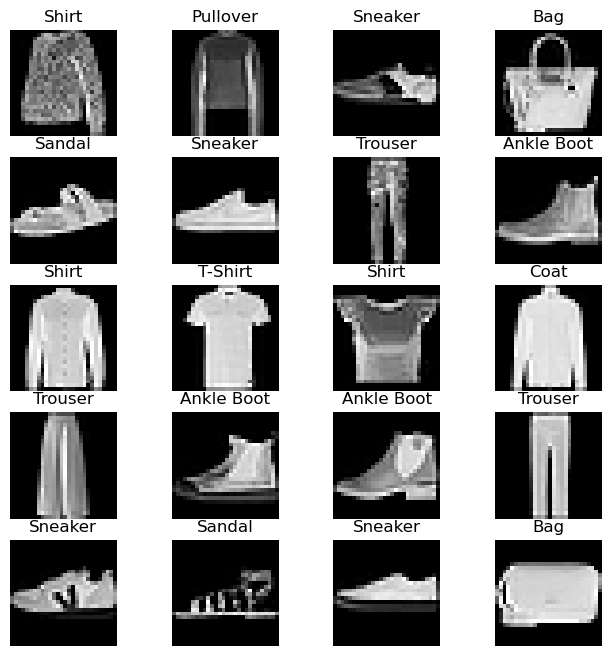

In [8]:
fig = plt.figure(figsize = (8, 8))
columns = 4
rows = 5

for i in range(1, columns * rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis("off")
    plt.imshow(img, cmap = "gray")
    
plt.show()

In [11]:
class FashionDNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 28 * 28 = 784
        self.fc1 = nn.Linear(in_features = 784, out_features = 256)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features = 256, out_features = 128)
        self.fc3 = nn.Linear(in_features = 128, out_features = 10)

    def forward(self, input_data):
        out = input_data.view(-1, 784)
        # 활성화 함수는 F.relu()로 forward() 함수에서 정의할 수도 있고
        # nn.ReLU()로 __init__에서 정의할 수도 있음
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out

- nn 과 nn.functional 의 비교
    - nn
        - 형태 : 클래스
        - 호출 방법 : 하이퍼파라미터를 전달한 후 함수 호출을 통해 데이터 전달
        - 위치 : nn.Sequential 내에 위치
            - \_\_init__() 내
            
    - nn.functional (F)
        - 형태 : 함수
        - 호출 방법 : 함수를 호출할 때 하이퍼파라미터, 데이터 전달
        - 위치 : nn.Sequential 바깥
            - forward() 함수 내

In [12]:
# 심층 신경망 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## 모델 학습

In [17]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        # Autograd 는 자동 미분을 수행하는 파이토치의 핵심 패키지
        # 자동 미분에 대한 값을 저장
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        # 50으로 나누어 떨어질때
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}")

Iteration: 500, Loss: 0.5682289600372314, Accuracy: 83.8499984741211
Iteration: 1000, Loss: 0.45121583342552185, Accuracy: 84.98999786376953
Iteration: 1500, Loss: 0.3673449456691742, Accuracy: 85.12000274658203
Iteration: 2000, Loss: 0.3407456576824188, Accuracy: 85.25
Iteration: 2500, Loss: 0.24506023526191711, Accuracy: 86.08000183105469
Iteration: 3000, Loss: 0.2752365469932556, Accuracy: 86.61000061035156
